# 利用Doc2Vec實作新聞分群
### 參考來源:
### 1. 壹讀的翻譯文章：https://read01.com/xoGyG4.html
### 2. 原文：https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
### ps. 由於原文章的程式碼是Python2，原作者有在留言提點到一些版本的更改方法，參考後順利完成Python3的程式，原文章是監督式的分類，當時嘗試準確率(acuurancy)約八成，也是使用logistic，這邊是嘗試使用分群的，基本上在轉成向量的部分代碼都一樣，只是最後分類或分群，下次再更新分類的部分。


# 1.載入套件
#### 　　(1)　jieba斷詞：處理中文斷詞
##### 　　　改為中文繁體字典,預設是簡體，可到jieba的GitHub下載
##### 　　　https://github.com/fxsjy/jieba/blob/master/extra_dict/dict.txt.big
#### 　　(2)　Pandas：將資料轉成DataFrame使用( 結構自由的表格 )
#### 　　(3)　wordcloud：文字雲套件
#### 　　(2)　random：用於隨機生成

In [5]:
import pandas as pd
import numpy as np
import jieba
#改為中文繁體字典,預設是簡體，可到jieba的GitHub下載
jieba.set_dictionary('dict.txt.big') 
from wordcloud import WordCloud
import random

# 2.過濾停用詞
#### 　　(1)　由於jieba是進入分析才會有停用詞的選項( 如TF-IDF、TextRank )，這邊只使用斷詞的部分，所以停用詞要自己去除
#### 　　　　　　引用自 https://gist.github.com/glenbot/4684356　set會過濾重複值，取「交集」，減少檢查的次數。

In [6]:
def StopWdFilter(user_input, stop_words):
    """Sanitize using intersection and list.remove()"""
    # Downsides:
    #   - Looping over list while removing from it?
    #     http://stackoverflow.com/questions/1207406/remove-items-from-a-list-while-iterating-in-python

    stop_words = set(stop_words)
    for sw in stop_words.intersection(user_input):
        while sw in user_input:
            user_input.remove(sw)

    return user_input

# 3. 把文章的List斷詞且過濾停用詞(StopWords)
#### 　　　　ps. 一般在停用詞的部分，會將標點符號及常見的字詞都濾掉，一方面是減少維度跟找出特徵，但因為我後面特徵萃取feature
#### 　　　　　　extraction所使用的方法是Doc2Vec，在維度上是可控制的，而且這個演算法會考慮到字詞的順序，所以像逗號對它來說
#### 　　　　　　是有意義的。所以這邊所過濾的字詞主要是跟文意無關的，一般文字探勘在過濾字詞的部分會比較多

In [7]:
def CutWithFilter(CorpusList):
    result=[]
    for y in [jieba.cut(x) for x in CorpusList]:
        content = StopWdFilter([ _ for _ in y], stopwords)
        result.append(content)
    return result
#所以我選擇所過濾的是跟「文意」比較無關的符號
stopwords = ['〔','〕','／','（','）','「','」','『','』','\n','nan']
#像下面這種比較是傳統文字探勘在過濾字詞可能過濾的一些字詞
#stopwords = ['〔','〕','／','（','）','「','」','『','』','的','就是','這個','可以','一定'\
#             ,'一個','nan','沒有','我們','不是','不用','不是','自己','只要','大家','覺得','因為'\
#             ,'對於','起來','如果','每個','很多','一樣','時候','加上','使用','只是']

# 4. 把文件讀進來（以自由時報政治、生活、社會新聞為範例）
## 把新聞標題跟內文以空格串接，作為分析的一個單位的Corpus，然後斷詞
#### ps. 這邊使用的是無監督式的分群，原參考範例是監督式的，我嘗試分類正確率大概是八成

In [8]:
#527篇政治新聞
politics_df = pd.read_csv(r'liberty.csv')
#1367篇生活新聞
life_df = pd.read_csv(r'life.csv')
#721篇社會新聞
society_df= pd.read_csv(r'society.csv')

#將標題與內容合成一個Corpus
politics = politics_df.NewsTitle + " " + politics_df.NewsContent
society  = society_df.NewsTitle  + " " + society_df.NewsContent
life     = life_df.NewsTitle     + " " + life_df.NewsContent

# 5. 斷詞後存成一個List

In [ ]:
Pol_List = CutWithFilter(politics)
Soc_List = CutWithFilter(society)
Lfe_List = CutWithFilter(life)


# 6. 把gensim, Doc2Vec的套件匯入

In [ ]:
import gensim
Lsent = gensim.models.doc2vec.LabeledSentence
def labelizeNews(News, label_type):
    labelized = []
    #enumertate include index
    for i, v in enumerate(News):
        label = '%s_%s' %(label_type,i)
        labelized.append(Lsent(v, [label]))
    return labelized   

# 7. 將每個問題的文章給一個編號，方便分析完對應

In [11]:
Train_Pol = labelizeNews(Pol_List,'Politics')
Train_Soc = labelizeNews(Soc_List,'Society')
Train_Lfe = labelizeNews(Lfe_List,'Life')


# 8. 設定Doc2Vec參數   (使用seed or save model 來排除訓練的隨機成分，如果需要每次的向量結果相同

#### 每一個Corpus產出400維的向量，預設使用3個核心做運算

In [12]:
size = 400   
model_dm = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=3)
model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5,dm=0, workers=3)

# 9. 訓練集，把Label後的新聞List接起來

In [13]:
Train_All =  Train_Pol + Train_Soc + Train_Lfe


# Build vocabulary from a sequence of sentences (can be a once-only generator stream). Each sentence must be a list of unicode strings.
##### https://radimrehurek.com/gensim/models/word2vec.html

##### build_vocab(sentences, keep_raw_vocab=False, trim_rule=None, progress_per=10000, update=False)

In [14]:
model_dm.build_vocab(Train_All)
model_dbow.build_vocab(Train_All)

In [48]:
#model_dm.save('WCloud_dm')
#model_dbow.save('WCloud_dbow')

# 10. 訓練十次，每次隨機交換文章順序    (由於是隨機, 要每次結果完全相同也可以固定訓練次序)

In [15]:
for epoch in range(10):
    perm = np.random.permutation(len(Train_All))
    model_dm.train([Train_All[x] for x in perm])
    model_dbow.train([Train_All[x] for x in perm])

# 10-1. 可以把模型存起來，下次直接取回向量

In [13]:
#model_dm = model_dm.load(r'model\model_dm')
#model_dbow = model_dbow.load(r'model\model_dbow')


# 11. 取出文章向量

In [16]:
def getVecs(model, corpus, size):
    vecs = [model.docvecs[z.tags[0]].reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

# 12. 取出兩個模型 dm, dbow 

In [17]:
Train_Pol_vecs_dm = getVecs(model_dm, Train_Pol, size)
Train_Pol_vecs_dbow = getVecs(model_dbow, Train_Pol, size)
Pol_train_vecs = np.hstack((Train_Pol_vecs_dm, Train_Pol_vecs_dbow))

In [18]:
Train_Soc_vecs_dm = getVecs(model_dm, Train_Soc, size)
Train_Soc_vecs_dbow = getVecs(model_dbow, Train_Soc, size)
Soc_train_vecs = np.hstack((Train_Soc_vecs_dm, Train_Soc_vecs_dbow))

In [19]:
Train_Lfe_vecs_dm = getVecs(model_dm, Train_Lfe, size)
Train_Lfe_vecs_dbow = getVecs(model_dbow, Train_Lfe, size)
Lfe_train_vecs = np.hstack((Train_Lfe_vecs_dm, Train_Lfe_vecs_dbow))

# 13. 載入scikit learn 套件 kmeans; 並將Doc2Vec的向量做分群
# 將所有新聞嘗試分50群，並找出比較小的群體做觀察

In [20]:
from sklearn.cluster import KMeans
#固定random state 隨機初始值 fixed the seed
All_vecs = np.vstack((Pol_train_vecs, Soc_train_vecs, Lfe_train_vecs))
All_kmeans = KMeans(n_clusters=50, random_state=0).fit(All_vecs)
#Pol_kmeans = KMeans(n_clusters=5, random_state=0).fit(Pol_train_vecs)
#Soc_kmeans = KMeans(n_clusters=5, random_state=0).fit(Soc_train_vecs)
#Lfe_kmeans = KMeans(n_clusters=5, random_state=0).fit(Lfe_train_vecs)

In [21]:
#清一下記憶體
import gc
gc.collect()

0

# 14. 將分群結果塞回各問題的DataFrame

In [22]:
#將所有新聞合併成一個DataFraem 請注意順序
All_News_df = politics_df.copy()
All_News_df = All_News_df.append(society_df).append(life_df)

In [23]:
#全部斷詞後的List 請注意順序!
All_List = Pol_List + Soc_List + Lfe_List 

In [24]:
#經分類結果分類放到原本的Dataframe
All_News_df['Cluster'] = All_kmeans.labels_

#politics_df['Cluster'] = Pol_kmeans.labels_
#society_df['Cluster'] = Soc_kmeans.labels_
#life_df['Cluster'] = Lfe_kmeans.labels_

In [25]:
#輸出分類結果
All_News_df.to_excel('All_News_50gp.xlsx')

In [26]:
gc.collect()

45

# 15. 輸出文字雲　將每個分群的文章接起來，格式是斷詞後並以空格連結的字串，用文字雲單純觀看高頻文字，嘗試解釋分群，可以到輸出的Excel，把同一群的文章內容看一下
#### ps. 這邊是顯示第五群的文字雲，主要是當時火熱的同婚議題，但是也有一些不相干的文章被納入這個群體。

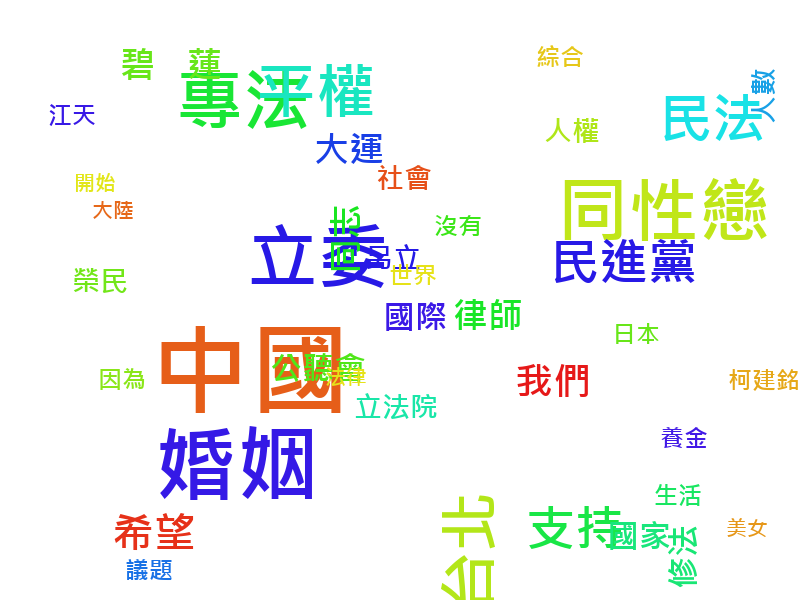

In [32]:
WC_Str=''
for i, x in enumerate(All_kmeans.labels_):
    if x == 5:
        WC_Str += ' '.join(All_List[i])

ww = WordCloud(max_font_size=100, relative_scaling=1,max_words=40,width=800, height=600,background_color='white',random_state=0,\
               stopwords=['記者','指出','報導','表示','台灣','今天','可以','一起','除了','自己'])\
               .generate(WC_Str)
ww.font_path = 'C:\Windows\Fonts\msjhbd' #微軟正黑體的路徑；字體可以自己設定，預設是英文的遇到中文會讀不出來
ww.to_image()
#ww.to_file('./pic/50gp_5.jpg') 可輸出圖檔